# Big Data Project: Analysis of IMDb Dataset
This project focuses on analyzing IMDb data to understand trends in movie releases and genre distributions over time.


## Introduction
The primary goal of this project is to analyze trends in movie releases and genres using the IMDb dataset from 2000 to 2024. The project involves data preprocessing, analysis, and visualization using PySpark to handle the large dataset effectively.


In [69]:
from pyspark.sql import SparkSession
from pyspark import SparkConf, StorageLevel
import pyspark.sql.functions as F
from pyspark.sql.functions import col, split, explode, year
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd


## Spark Configuration
In this section, we configure the Spark session to handle the IMDb dataset. We set various parameters such as the master URL, application name, and memory allocations for the driver and executor. This configuration ensures that Spark can efficiently process the large dataset.

In [5]:
# conf = SparkConf().setMaster('local[4]').setAppName("Amazon products reviews") \
# .set("spark.driver.memory", "4g") \
# .set("spark.executor.memory", "4g") \
# .set("spark.driver.memoryOverhead", "256m") \
# .set("spark.executor.memoryOverhead", "256m") \
# .set("spark.sql.shuffle.partitions", "50") \
# .set("spark.ui.showConsoleProgress", "false") \
# .set("spark.executor.extraJavaOptions", "-XX:+UseG1GC -XX:MaxGCPauseMillis=200")

# spark = SparkSession.builder.config(conf=conf).getOrCreate()
# sc = spark.sparkContext

conf = SparkConf().setMaster('local[*]').setAppName("IMDB Dataset") \
.set("spark.driver.memory", "8g") \
.set("spark.executor.memory", "12g") \
.set("spark.driver.memoryOverhead", "512m") \
.set("spark.executor.memoryOverhead", "512m")

spark = SparkSession.builder.config(conf=conf).getOrCreate()
sc = spark.sparkContext



## Data Loading
In this section, we load the IMDb dataset files into Spark DataFrames. Each file is read from the HDFS location with appropriate options to handle headers, delimiters, and multiline fields. The datasets include information about names, titles, principals, ratings, crew, episodes, and alternate titles.

In [6]:
name_basics = spark.read.options(
    header=True,        # Indicates that the file has a header row
    delimiter='\t',     # Specifies that the delimiter is a tab
    escape='"',         # Handles escaped quotes
    multiline=True      # Allows parsing of multiline fields
).csv('hdfs://localhost:9000/input/dataset/name.basics.tsv')

title_basics = spark.read.options(
    header=True,        # Indicates that the file has a header row
    delimiter='\t',     # Specifies that the delimiter is a tab
    escape='"',         # Handles escaped quotes
    multiline=True      # Allows parsing of multiline fields
).csv('hdfs://localhost:9000/input/dataset/title.basics.tsv')

title_principals = spark.read.options(
    header=True,        # Indicates that the file has a header row
    delimiter='\t',     # Specifies that the delimiter is a tab
    escape='"',         # Handles escaped quotes
    multiline=True      # Allows parsing of multiline fields
).csv('hdfs://localhost:9000/input/dataset/title.principals.tsv')

title_ratings = spark.read.options(
    header=True,        # Indicates that the file has a header row
    delimiter='\t',     # Specifies that the delimiter is a tab
    escape='"',         # Handles escaped quotes
    multiline=True      # Allows parsing of multiline fields
).csv('hdfs://localhost:9000/input/dataset/title.ratings.tsv')

title_crew = spark.read.options(
    header=True,        # Indicates that the file has a header row
    delimiter='\t',     # Specifies that the delimiter is a tab
    escape='"',         # Handles escaped quotes
    multiline=True      # Allows parsing of multiline fields
).csv('hdfs://localhost:9000/input/dataset/title.crew.tsv')

title_episode = spark.read.options(
    header=True,        # Indicates that the file has a header row
    delimiter='\t',     # Specifies that the delimiter is a tab
    escape='"',         # Handles escaped quotes
    multiline=True      # Allows parsing of multiline fields
).csv('hdfs://localhost:9000/input/dataset/title.episode.tsv')

title_akas = spark.read.options(
    header=True,        # Indicates that the file has a header row
    delimiter='\t',     # Specifies that the delimiter is a tab
    escape='"',         # Handles escaped quotes
    multiline=True      # Allows parsing of multiline fields
).csv('hdfs://localhost:9000/input/dataset/title.akas.tsv')



## Genre Trends Over Time
In this section, we analyze the trends in movie genres over time. We start by filtering out titles that have no genres and then split the genres into individual rows. We group the data by year and genre to count the number of titles per genre each year. Finally, we visualize the trends of the top 10 genres from 2000 to 2024 using a line plot.

In [17]:
# Filter out titles that have no genres
titles_with_genres = title_basics.filter(F.col("genres").isNotNull())

# Split the genres (comma separated) into individual genres
from pyspark.sql.functions import explode, split

# Split genres and explode into rows
titles_with_genres_exploded = titles_with_genres.withColumn("genre", explode(split(F.col("genres"), ",")))

# Show the first few rows of the exploded data
titles_with_genres_exploded.select("tconst", "genre", "startYear").show(5)


+---------+-----------+---------+
|   tconst|      genre|startYear|
+---------+-----------+---------+
|tt0000001|Documentary|     1894|
|tt0000001|      Short|     1894|
|tt0000002|  Animation|     1892|
|tt0000002|      Short|     1892|
|tt0000003|  Animation|     1892|
+---------+-----------+---------+
only showing top 5 rows



In [18]:
# Group by year and genre, and count how many times each genre appears per year
genre_counts_by_year = titles_with_genres_exploded.groupBy("startYear", "genre").agg(F.count("tconst").alias("num_titles"))

# Show a preview of the counts
genre_counts_by_year.show(5)


+---------+-------+----------+
|startYear|  genre|num_titles|
+---------+-------+----------+
|     1905|     \N|         4|
|     1912| Comedy|      2657|
|     1922|Mystery|        48|
|     1925|  Crime|        56|
|     1927|Fantasy|        13|
+---------+-------+----------+
only showing top 5 rows



In [19]:
# Sort by startYear and count of titles per genre, descending order
genre_trends = genre_counts_by_year.orderBy("startYear", F.desc("num_titles"))

# Show the top genres for the first few years
genre_trends.filter(F.col("startYear").between(2000, 2020)).show(20)


+---------+-----------+----------+
|startYear|      genre|num_titles|
+---------+-----------+----------+
|     2000|      Drama|     30204|
|     2000|     Comedy|     20695|
|     2000|    Romance|     11600|
|     2000|Documentary|     10751|
|     2000|     Family|     10027|
|     2000|  Talk-Show|      9247|
|     2000|       News|      8136|
|     2000|         \N|      7930|
|     2000|  Game-Show|      6397|
|     2000|  Animation|      6389|
|     2000|      Short|      6277|
|     2000|     Action|      6078|
|     2000|  Adventure|      5457|
|     2000|      Crime|      5135|
|     2000|      Music|      4366|
|     2000| Reality-TV|      3119|
|     2000|      Adult|      2935|
|     2000|      Sport|      2616|
|     2000|    Mystery|      2277|
|     2000|    Fantasy|      2090|
+---------+-----------+----------+
only showing top 20 rows



<Figure size 1400x800 with 0 Axes>

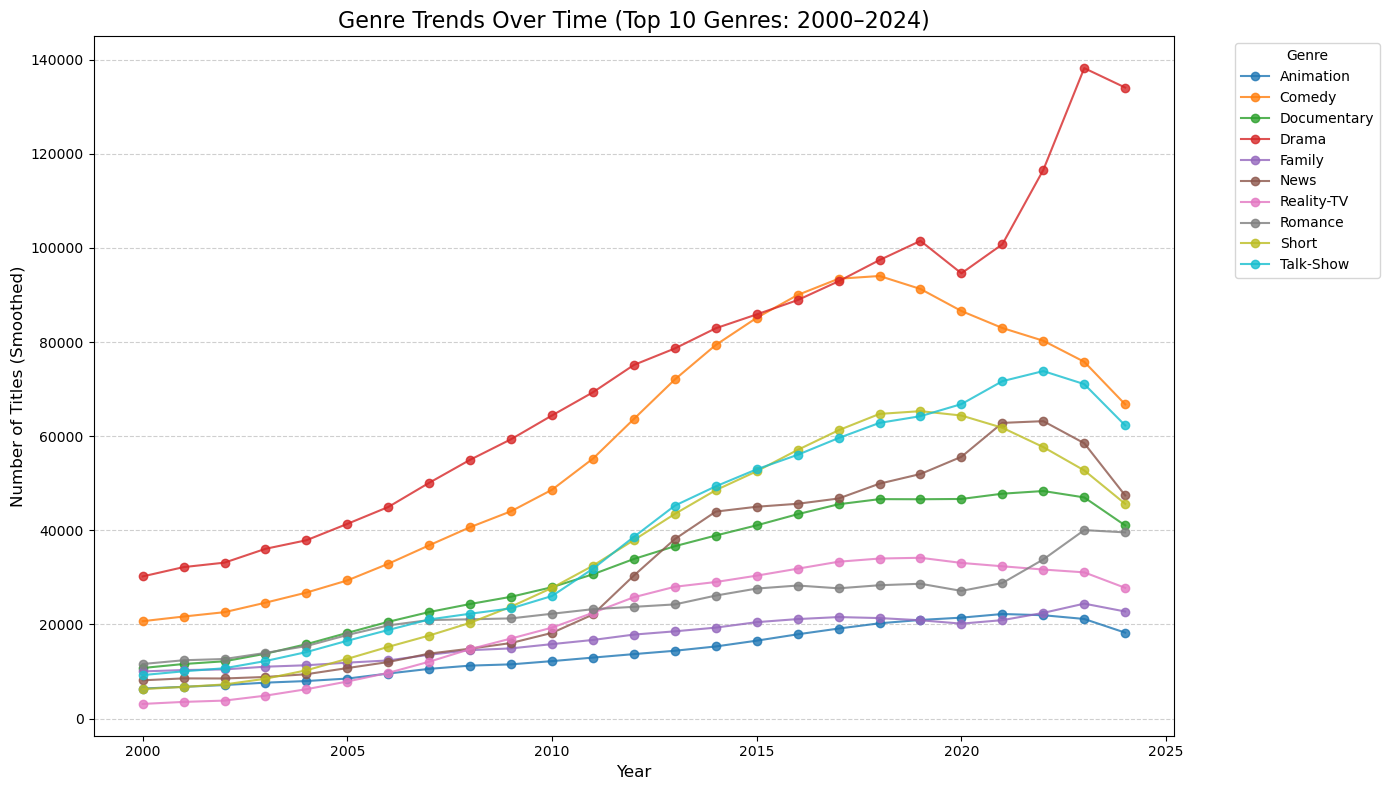

In [36]:
import matplotlib.pyplot as plt

# Convert to Pandas for easier manipulation
genre_trends_pd = genre_trends.toPandas()

# Convert 'startYear' to numeric, coercing errors
genre_trends_pd['startYear'] = pd.to_numeric(genre_trends_pd['startYear'], errors='coerce')

# Drop rows where 'startYear' could not be converted to a number
genre_trends_pd = genre_trends_pd.dropna(subset=['startYear'])

# Convert 'startYear' to integer for filtering
genre_trends_pd['startYear'] = genre_trends_pd['startYear'].astype(int)

# Filter for years between 2000 and 2024
filtered_genre_trends = genre_trends_pd[(genre_trends_pd['startYear'] >= 2000) & (genre_trends_pd['startYear'] <= 2024)]

# Get the top genres by total titles
top_genres = (
    filtered_genre_trends.groupby('genre')['num_titles']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

# Filter data for the top genres
filtered_data = filtered_genre_trends[filtered_genre_trends['genre'].isin(top_genres)]

# Pivot for easier plotting
pivot_data = filtered_data.pivot_table(index='startYear', columns='genre', values='num_titles', aggfunc='sum', fill_value=0)

# Smooth data using a rolling average (optional: adjust window size)
pivot_data = pivot_data.rolling(window=3, min_periods=1).mean()

# Plot
plt.figure(figsize=(14, 8))
pivot_data.plot(kind='line', figsize=(14, 8), marker='o', alpha=0.8)

plt.title('Genre Trends Over Time (Top 10 Genres: 2000–2024)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Titles (Smoothed)', fontsize=12)
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## Genre Trends Analysis
In this section, we analyze the trends in movie genres over time. We start by filtering out titles that have no genres and then split the genres into individual rows. We group the data by year and genre to count the number of titles per genre each year. Finally, we visualize the trends of the top 10 genres from 2000 to 2024 using a line plot.

In [49]:
title_basics.show(5)

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|tt0000001|    short|          Carmencita|          Carmencita|      0|     1894|     \N|             1|   Documentary,Short|
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|      0|     1892|     \N|             5|     Animation,Short|
|tt0000003|    short|        Poor Pierrot|      Pauvre Pierrot|      0|     1892|     \N|             5|Animation,Comedy,...|
|tt0000004|    short|         Un bon bock|         Un bon bock|      0|     1892|     \N|            12|     Animation,Short|
|tt0000005|    short|    Blacksmith Scene|    Blacksmith Scene|      0|     1893|     \N|             1|              

In [50]:
title_ratings.show(5)

+---------+-------------+--------+
|   tconst|averageRating|numVotes|
+---------+-------------+--------+
|tt0000001|          5.7|    2109|
|tt0000002|          5.6|     284|
|tt0000003|          6.4|    2135|
|tt0000004|          5.3|     182|
|tt0000005|          6.2|    2863|
+---------+-------------+--------+
only showing top 5 rows



In [57]:
imdb_movies = title_basics[title_basics['titleType'] == 'movie']


In [58]:
imdb_movies.show(5)

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|tt0000009|    movie|          Miss Jerry|          Miss Jerry|      0|     1894|     \N|            45|             Romance|
|tt0000147|    movie|The Corbett-Fitzs...|The Corbett-Fitzs...|      0|     1897|     \N|           100|Documentary,News,...|
|tt0000502|    movie|            Bohemios|            Bohemios|      0|     1905|     \N|           100|                  \N|
|tt0000574|    movie|The Story of the ...|The Story of the ...|      0|     1906|     \N|            70|Action,Adventure,...|
|tt0000591|    movie|    The Prodigal Son|   L'enfant prodigue|      0|     1907|     \N|            90|              

In [59]:
imdb_movies = imdb_movies.drop("endYear")

In [60]:
imdb_movies.show(5)

+---------+---------+--------------------+--------------------+-------+---------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+---------+--------------+--------------------+
|tt0000009|    movie|          Miss Jerry|          Miss Jerry|      0|     1894|            45|             Romance|
|tt0000147|    movie|The Corbett-Fitzs...|The Corbett-Fitzs...|      0|     1897|           100|Documentary,News,...|
|tt0000502|    movie|            Bohemios|            Bohemios|      0|     1905|           100|                  \N|
|tt0000574|    movie|The Story of the ...|The Story of the ...|      0|     1906|            70|Action,Adventure,...|
|tt0000591|    movie|    The Prodigal Son|   L'enfant prodigue|      0|     1907|            90|               Drama|
+---------+---------+--------------------+--------------

In [63]:
imdb_movies_year = (
    imdb_movies
    .groupBy("startYear")                       # Group by startYear
    .count()                                   # Count occurrences
    .orderBy(F.col("count").desc())            # Sort by count in descending order
)

# Resetting index is equivalent to renaming columns and ensuring all are in order
imdb_movies_year = imdb_movies_year.withColumnRenamed("count", "value_counts")

# Show the resulting DataFrame
imdb_movies_year.show()


+---------+------------+
|startYear|value_counts|
+---------+------------+
|       \N|      101817|
|     2022|       20600|
|     2023|       20156|
|     2018|       19303|
|     2019|       19249|
|     2017|       19065|
|     2021|       18948|
|     2016|       18600|
|     2024|       18249|
|     2015|       17407|
|     2014|       16803|
|     2020|       16547|
|     2013|       15605|
|     2012|       14942|
|     2011|       13873|
|     2010|       12917|
|     2009|       12088|
|     2008|       10641|
|     2007|        9165|
|     2006|        8376|
+---------+------------+
only showing top 20 rows



In [64]:
# Rename the columns
imdb_movies_year = imdb_movies_year \
    .withColumnRenamed("startYear", "year") \
    .withColumnRenamed("value_counts", "num_of_films")

# Drop the first row (equivalent to dropping the row with index 0 in Pandas)
# Assuming you're referring to dropping the first row, which might have the highest count
imdb_movies_year = imdb_movies_year.filter(F.col("year") != 0)

# Show the result
imdb_movies_year.show()


+----+------------+
|year|num_of_films|
+----+------------+
|2022|       20600|
|2023|       20156|
|2018|       19303|
|2019|       19249|
|2017|       19065|
|2021|       18948|
|2016|       18600|
|2024|       18249|
|2015|       17407|
|2014|       16803|
|2020|       16547|
|2013|       15605|
|2012|       14942|
|2011|       13873|
|2010|       12917|
|2009|       12088|
|2008|       10641|
|2007|        9165|
|2006|        8376|
|2005|        7805|
+----+------------+
only showing top 20 rows



In [65]:
from pyspark.sql.types import IntegerType

# Cast 'year' column to IntegerType
imdb_movies_year = imdb_movies_year.withColumn("year", F.col("year").cast(IntegerType()))

# Filter rows based on the year range
imdb_data_year = imdb_movies_year.filter((F.col("year") >= 1990) & (F.col("year") <= 2024))

# Show the first 7 rows
imdb_data_year.show(7)


+----+------------+
|year|num_of_films|
+----+------------+
|2022|       20600|
|2023|       20156|
|2018|       19303|
|2019|       19249|
|2017|       19065|
|2021|       18948|
|2016|       18600|
+----+------------+
only showing top 7 rows



In [70]:
# Plotting the data 
fig = px.bar(imdb_data_year, x='year', y='num_of_films', color='num_of_films',
              labels={'year': 'Release Year', 'num_of_films': 'Total Movies'},
              title='Distribution of Movies by Release Year', template='presentation')
fig.show()

     ---------------------------------------- 15.6/15.6 MB 9.1 MB/s eta 0:00:00
